# Lab: Generative AI for Data Science (All 3 Scenarios)

## Common Setup

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Display options
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['figure.figsize'] = (8, 5)


## Scenario 1: Retail Inventory Analysis

### AI Prompt:

> *Prompt:*  
> “I’m analyzing a retail inventory DataFrame with columns `product_id`, `category`, `stock_level`, `last_restock_date` (string or datetime), `sales_last_30_days`, `supplier_lead_time` (days), and `unit_cost`.  
> Please generate **pandas** code to:  
> 1) Calculate a sensible **inventory_turnover** metric,  
> 2) Flag **slow‑moving** items,  
> 3) **Predict stockouts** using days‑of‑cover vs. lead time,  
> 4) Produce **clear visualizations** by category and top/bottom performers.  
> Include: date parsing, validation for negative/NaN values, comments, and simple error handling.”


### Generated Code:

In [ ]:
# (Sample initial AI output — simplified)
def analyze_inventory(df):
    df = df.copy()
    # Parse dates
    if df['last_restock_date'].dtype == 'O':
        df['last_restock_date'] = pd.to_datetime(df['last_restock_date'], errors='coerce')
    # Basic turnover
    df['inventory_turnover'] = df['sales_last_30_days'] / df['stock_level'].replace(0, np.nan)
    # Slow moving heuristic
    df['is_slow_moving'] = df['inventory_turnover'] < df['inventory_turnover'].median()
    # Days of cover and stockout prediction
    daily_sales = df['sales_last_30_days'] / 30.0
    df['days_of_cover'] = df['stock_level'] / daily_sales.replace(0, np.nan)
    df['predict_stockout'] = df['days_of_cover'] < df['supplier_lead_time']
    # Basic plots
    df.groupby('category')['inventory_turnover'].mean().plot(kind='bar', title='Turnover by Category')
    plt.show()
    return df


### Follow‑up Prompts:

- “Please add **data validation** for negative values and NaNs; coerce invalid numbers to NaN and report counts.”  
- “Make the **slow‑moving** rule configurable (e.g., bottom 25% by turnover).”  
- “Add **top 10 highest/lowest turnover** tables and a **scatter plot** of `stock_level` vs `sales_last_30_days` labeled by category.”  
- “Ensure plots have axis labels, titles, and readable formatting.”


### Final Solution:

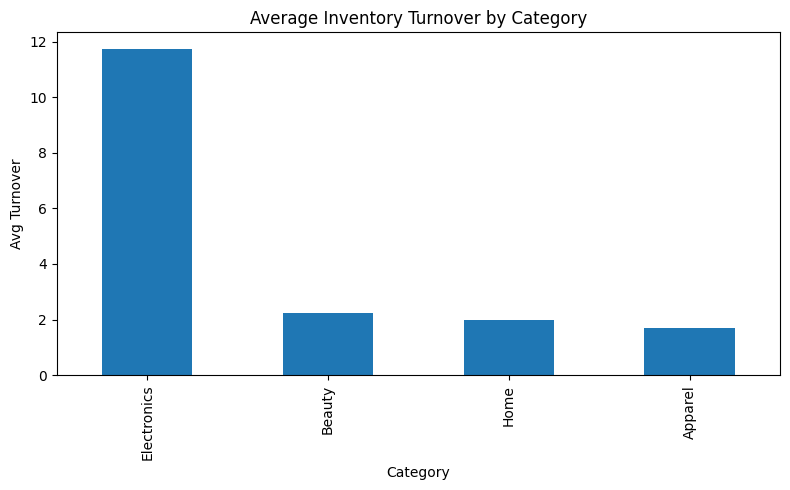

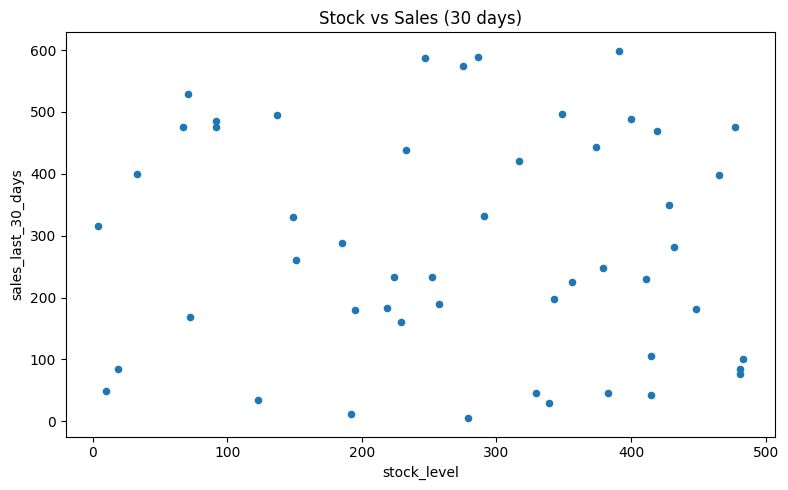

Validation report:
 {'negative_stock_level': 0, 'negative_sales_last_30_days': 0, 'negative_supplier_lead_time': 0, 'negative_unit_cost': 0, 'null_counts': {'product_id': 0, 'category': 0, 'stock_level': 0, 'last_restock_date': 0, 'sales_last_30_days': 0, 'supplier_lead_time': 0, 'unit_cost': 0}}

Top 5 by turnover:
    product_id  inventory_turnover
38       P039             78.7500
40       P041             12.1212
16       P017              7.4507
32       P033              7.1045
14       P015              5.2826

Bottom 5 by turnover:
    product_id  inventory_turnover
17       P018              0.0179
8        P009              0.0625
5        P006              0.0855
49       P050              0.1012
48       P049              0.1175


: 

: 

: 

In [ ]:
def validate_inventory_df(df):
    """Validate schema and values; return a cleaned copy and a validation report dict."""
    required_cols = [
        'product_id', 'category', 'stock_level', 'last_restock_date',
        'sales_last_30_days', 'supplier_lead_time', 'unit_cost'
    ]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    
    out = df.copy()
    # Parse dates
    out['last_restock_date'] = pd.to_datetime(out['last_restock_date'], errors='coerce')
    
    # Coerce numerics
    num_cols = ['stock_level', 'sales_last_30_days', 'supplier_lead_time', 'unit_cost']
    for c in num_cols:
        out[c] = pd.to_numeric(out[c], errors='coerce')
    
    # Basic validations
    report = {}
    for c in num_cols:
        neg_count = (out[c] < 0).sum(skipna=True)
        report[f'negative_{c}'] = int(neg_count)
        if neg_count > 0:
            out.loc[out[c] < 0, c] = np.nan  # invalidate negatives
    
    report['null_counts'] = out.isna().sum().to_dict()
    return out, report


def analyze_inventory(
    df,
    slow_moving_method='quantile',  # 'quantile' or 'median'
    slow_moving_param=0.25          # bottom 25% by default
):
    """Compute turnover, slow-moving flags, stockout predictions, and visualizations."""
    df_clean, report = validate_inventory_df(df)
    
    # Derived metrics
    df_clean['inventory_turnover'] = df_clean['sales_last_30_days'] / df_clean['stock_level'].replace({0: np.nan})
    df_clean['daily_sales'] = df_clean['sales_last_30_days'] / 30.0
    df_clean['days_of_cover'] = df_clean['stock_level'] / df_clean['daily_sales'].replace({0: np.nan})
    df_clean['predict_stockout'] = df_clean['days_of_cover'] < df_clean['supplier_lead_time']
    
    # Slow-moving logic
    turnover = df_clean['inventory_turnover']
    if slow_moving_method == 'quantile':
        thresh = turnover.quantile(slow_moving_param)
    else:
        thresh = turnover.median()
    df_clean['is_slow_moving'] = turnover <= thresh
    
    # Summary tables
    top10 = df_clean.sort_values('inventory_turnover', ascending=False).head(10)
    bottom10 = df_clean.sort_values('inventory_turnover', ascending=True).head(10)
    
    # Visualizations
    ax = df_clean.groupby('category')['inventory_turnover'].mean().sort_values(ascending=False).plot(
        kind='bar', title='Average Inventory Turnover by Category')
    ax.set_xlabel('Category'); ax.set_ylabel('Avg Turnover')
    plt.tight_layout(); plt.show()
    
    ax = df_clean.plot(kind='scatter', x='stock_level', y='sales_last_30_days', title='Stock vs Sales (30 days)')
    plt.tight_layout(); plt.show()
    
    return df_clean, report, top10, bottom10


# --- Demo with synthetic data (safe to remove in production) ---
np.random.seed(7)
demo = pd.DataFrame({
    'product_id': [f'P{i:03d}' for i in range(1, 51)],
    'category': np.random.choice(['Apparel', 'Electronics', 'Home', 'Beauty'], size=50),
    'stock_level': np.random.randint(0, 500, size=50),
    'last_restock_date': (pd.Timestamp.today() - pd.to_timedelta(np.random.randint(1, 120, 50), unit='D')).astype(str),
    'sales_last_30_days': np.random.randint(0, 600, size=50),
    'supplier_lead_time': np.random.randint(1, 30, size=50),
    'unit_cost': np.random.uniform(2, 120, size=50).round(2)
})

inv_results, inv_report, inv_top10, inv_bottom10 = analyze_inventory(demo)
print("Validation report:\n", inv_report)
print("\nTop 5 by turnover:\n", inv_top10[['product_id', 'inventory_turnover']].head())
print("\nBottom 5 by turnover:\n", inv_bottom10[['product_id', 'inventory_turnover']].head())


## Scenario 2: Website Analytics Debug

### AI Prompt:

> *Prompt:*  
> “Here is a buggy function that calculates engagement metrics from `logs_df` with columns `session_id`, `device_type`, `duration` (in seconds), and `page_views`.  
> Please **fix the bounce rate**, compute **average session time** correctly, validate negatives/NaNs, and return a tidy metrics DataFrame plus device‑level summary. Include comments and plots.”


### Generated Code:

In [ ]:
# (Sample initial AI output — simplified)
def analyze_user_engagement(logs_df):
    df = logs_df.copy()
    df['duration'] = pd.to_numeric(df['duration'], errors='coerce')
    df['page_views'] = pd.to_numeric(df['page_views'], errors='coerce')
    df = df.dropna(subset=['session_id'])
    
    # Bounce rate: percent of sessions with exactly one page_view
    session_pageviews = df.groupby('session_id')['page_views'].sum()
    bounce_rate = (session_pageviews == 1).mean() * 100
    
    # Avg session time in seconds
    session_duration = df.groupby('session_id')['duration'].sum()
    avg_session_time = session_duration.mean()
    
    device_summary = df.groupby('device_type').agg(
        sessions=('session_id', 'nunique'),
        avg_duration=('duration', 'mean'),
        total_page_views=('page_views', 'sum')
    ).reset_index()
    
    metrics = pd.DataFrame({
        'metric': ['bounce_rate_pct', 'avg_session_time_sec', 'pages_per_session'],
        'value': [bounce_rate, avg_session_time, (session_pageviews.mean())]
    })
    return metrics, device_summary


### Follow‑up Prompts:

- “Reject negative **duration** or **page_views** values and report how many were removed.”  
- “Compute **pages_per_session** as total pages / total sessions (not mean of per‑session sums).”  
- “Add **visualizations**: bar chart of sessions by device, and boxplot of session durations.”  
- “Format time in **mm:ss** for readability.”


### Final Solution:

In [ ]:
def validate_logs_df(df):
    """Clean and validate logs, dropping nonsensical values and reporting a summary."""
    out = df.copy()
    # Standardize columns
    required = ['session_id', 'device_type', 'duration', 'page_views']
    missing = [c for c in required if c not in out.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    
    out['duration'] = pd.to_numeric(out['duration'], errors='coerce')
    out['page_views'] = pd.to_numeric(out['page_views'], errors='coerce')
    
    report = {}
    # Drop rows without session_id
    before = len(out)
    out = out.dropna(subset=['session_id'])
    report['dropped_missing_session_id'] = int(before - len(out))
    
    # Remove negative/illogical values
    neg_dur = (out['duration'] < 0).sum(skipna=True)
    neg_pv = (out['page_views'] < 0).sum(skipna=True)
    report['negative_duration_rows'] = int(neg_dur)
    report['negative_page_view_rows'] = int(neg_pv)
    out = out[(out['duration'].isna()) | (out['duration'] >= 0)]
    out = out[(out['page_views'].isna()) | (out['page_views'] >= 0)]
    
    # Replace NaNs with 0 for additive metrics
    out['duration'] = out['duration'].fillna(0)
    out['page_views'] = out['page_views'].fillna(0)
    
    return out, report


def format_seconds(sec):
    """Format seconds as mm:ss for readability."""
    if pd.isna(sec):
        return '00:00'
    sec = int(round(sec))
    m, s = divmod(sec, 60)
    return f"{m:02d}:{s:02d}"


def analyze_user_engagement_fixed(logs_df):
    """Compute engagement metrics with validation and clear visualizations."""
    clean, report = validate_logs_df(logs_df)
    
    # Session-level aggregates
    session_metrics = clean.groupby('session_id').agg(
        pages=('page_views', 'sum'),
        duration=('duration', 'sum')
    )
    total_sessions = len(session_metrics)
    total_pages = session_metrics['pages'].sum()
    
    # Metrics
    bounce_rate_pct = (session_metrics['pages'].eq(1).mean() * 100.0) if total_sessions else 0.0
    avg_session_time_sec = session_metrics['duration'].mean() if total_sessions else 0.0
    pages_per_session = (total_pages / total_sessions) if total_sessions else 0.0
    
    metrics = pd.DataFrame({
        'metric': ['bounce_rate_pct', 'avg_session_time_sec', 'avg_session_time_mm_ss', 'pages_per_session'],
        'value': [bounce_rate_pct, avg_session_time_sec, format_seconds(avg_session_time_sec), pages_per_session]
    })
    
    # Device summary
    device_summary = clean.groupby('device_type').agg(
        sessions=('session_id', 'nunique'),
        avg_duration_sec=('duration', 'mean'),
        total_page_views=('page_views', 'sum')
    ).reset_index()
    
    # Visualizations
    ax = device_summary.set_index('device_type')['sessions'].plot(kind='bar', title='Sessions by Device')
    ax.set_xlabel('Device'); ax.set_ylabel('Sessions')
    plt.tight_layout(); plt.show()
    
    ax = session_metrics['duration'].plot(kind='box', title='Session Duration Distribution (sec)')
    ax.set_ylabel('Seconds')
    plt.tight_layout(); plt.show()
    
    return metrics, device_summary, report, session_metrics


# --- Demo with synthetic data (safe to remove in production) ---
np.random.seed(3)
logs_demo = pd.DataFrame({
    'session_id': np.random.choice([f'S{i:04d}' for i in range(1, 601)], size=2000),
    'device_type': np.random.choice(['mobile', 'desktop', 'tablet'], size=2000, p=[0.6, 0.3, 0.1]),
    'duration': np.random.gamma(shape=2.0, scale=40.0, size=2000) - 10,  # some negatives
    'page_views': np.random.poisson(lam=2.2, size=2000) - 1               # some negatives
})
metrics, device_summary, report, session_metrics = analyze_user_engagement_fixed(logs_demo)
print("Validation report:\n", report)
print("\nKey metrics:\n", metrics)
print("\nDevice summary (head):\n", device_summary.head())


## Scenario 3: Customer Segmentation Query (SQL)

### AI Prompt:

> *Prompt:*  
> “Write an optimized SQL query that selects: (1) users active in the last 30 days, (2) filters to top 20% by **total spend** in the same window, and (3) returns their preference trends (counts by theme/notifications). Use **CTEs**, proper **date filtering**, and a **window function** (e.g., `NTILE(5)`) to mark the top 20%. Also include total orders and average order value per user.”


### Generated SQL:

```sql
WITH recent_tx AS (
  SELECT t.user_id,
         DATE(t.transaction_date) AS d,
         t.amount
  FROM transactions t
  WHERE DATE(t.transaction_date) >= DATE('now', '-30 day')
),
spend AS (
  SELECT user_id,
         SUM(amount) AS total_spend,
         COUNT(*) AS orders,
         AVG(amount) AS avg_order_value
  FROM recent_tx
  GROUP BY user_id
),
active AS (
  SELECT ua.user_id
  FROM user_activity ua
  WHERE DATE(ua.last_login_date) >= DATE('now', '-30 day')
),
ranked AS (
  SELECT s.*, NTILE(5) OVER (ORDER BY total_spend DESC) AS spend_ntile
  FROM spend s
)
SELECT r.user_id, r.total_spend, r.orders, r.avg_order_value
FROM ranked r
JOIN active a ON a.user_id = r.user_id
WHERE r.spend_ntile = 1
ORDER BY r.total_spend DESC;
```


### Follow‑up Prompts:

- “Join **user_preferences** and return aggregated **preference trends** for the high‑value cohort.”  
- “Return **platform** mix from transactions for the cohort.”  
- “Ensure date filters use the same window for activity and spending.”  
- “If the database does not support `NTILE`, show a percentile‑based alternative.”


### Final Solution:

```sql
-- Active, high-value users (top 20% by spend in last 30 days) with preferences and platform mix
WITH tx_window AS (
  SELECT t.user_id,
         t.transaction_id,
         DATE(t.transaction_date) AS tx_date,
         t.amount,
         t.platform
  FROM transactions t
  WHERE DATE(t.transaction_date) >= DATE('now', '-30 day')
),
user_spend AS (
  SELECT user_id,
         SUM(amount) AS total_spend,
         COUNT(*) AS orders,
         AVG(amount) AS avg_order_value
  FROM tx_window
  GROUP BY user_id
),
active_users AS (
  SELECT ua.user_id
  FROM user_activity ua
  WHERE DATE(ua.last_login_date) >= DATE('now', '-30 day')
),
ranked_spend AS (
  SELECT us.*,
         NTILE(5) OVER (ORDER BY total_spend DESC) AS spend_ntile
  FROM user_spend us
),
high_value AS (
  SELECT rs.*
  FROM ranked_spend rs
  JOIN active_users au ON au.user_id = rs.user_id
  WHERE rs.spend_ntile = 1
),
prefs AS (
  SELECT up.user_id,
         up.communication_preference,
         up.interface_theme,
         up.notification_settings
  FROM user_preferences up
  WHERE up.user_id IN (SELECT user_id FROM high_value)
),
platform_mix AS (
  SELECT tw.user_id, tw.platform, COUNT(*) AS platform_orders
  FROM tx_window tw
  WHERE tw.user_id IN (SELECT user_id FROM high_value)
  GROUP BY tw.user_id, tw.platform
)
SELECT hv.user_id,
       hv.total_spend,
       hv.orders,
       hv.avg_order_value,
       p.communication_preference,
       p.interface_theme,
       p.notification_settings
FROM high_value hv
LEFT JOIN prefs p ON p.user_id = hv.user_id
ORDER BY hv.total_spend DESC;

-- Preference trends example:
-- SELECT interface_theme, COUNT(*) AS users FROM prefs GROUP BY interface_theme ORDER BY users DESC;
-- SELECT notification_settings, COUNT(*) AS users FROM prefs GROUP BY notification_settings ORDER BY users DESC;
-- Platform mix example:
-- SELECT platform, SUM(platform_orders) AS total_orders FROM platform_mix GROUP BY platform ORDER BY total_orders DESC;
```


### SQLite Demo

In [ ]:
# Build an in-memory SQLite demo with minimal synthetic data and run the final query
import sqlite3, random
conn = sqlite3.connect(':memory:')
cur = conn.cursor()

# Create tables
cur.executescript('''
CREATE TABLE user_activity (
  user_id INTEGER PRIMARY KEY,
  last_login_date TEXT,
  feature_usage_count INTEGER,
  account_type TEXT
);
CREATE TABLE transactions (
  transaction_id INTEGER PRIMARY KEY,
  user_id INTEGER,
  transaction_date TEXT,
  amount REAL,
  platform TEXT
);
CREATE TABLE user_preferences (
  user_id INTEGER PRIMARY KEY,
  communication_preference TEXT,
  interface_theme TEXT,
  notification_settings TEXT
);
''')

# Seed users
today = datetime.utcnow().date()
users = list(range(1, 51))

# user_activity
ua_rows = []
for u in users:
    # half of users logged in within last 30 days
    delta = random.randint(0, 45)
    ua_rows.append((u, str(today - timedelta(days=delta)), random.randint(0, 100), random.choice(['free','pro'])))
cur.executemany('INSERT INTO user_activity VALUES (?,?,?,?)', ua_rows)

# transactions
tx_rows = []
tid = 1
for u in users:
    for _ in range(random.randint(1, 10)):
        delta = random.randint(0, 35)  # some outside 30-day window
        tx_rows.append((tid, u, str(today - timedelta(days=delta)), round(random.uniform(5, 200), 2), random.choice(['web','ios','android'])))
        tid += 1
cur.executemany('INSERT INTO transactions VALUES (?,?,?,?,?)', tx_rows)

# user_preferences
prefs_rows = []
for u in users:
    prefs_rows.append((u, random.choice(['email','sms','push']),
                       random.choice(['light','dark','system']),
                       random.choice(['all','important-only','none'])))
cur.executemany('INSERT INTO user_preferences VALUES (?,?,?,?)', prefs_rows)
conn.commit()

final_query = '''
WITH tx_window AS (
  SELECT t.user_id,
         t.transaction_id,
         DATE(t.transaction_date) AS tx_date,
         t.amount,
         t.platform
  FROM transactions t
  WHERE DATE(t.transaction_date) >= DATE('now', '-30 day')
),
user_spend AS (
  SELECT user_id,
         SUM(amount) AS total_spend,
         COUNT(*) AS orders,
         AVG(amount) AS avg_order_value
  FROM tx_window
  GROUP BY user_id
),
active_users AS (
  SELECT ua.user_id
  FROM user_activity ua
  WHERE DATE(ua.last_login_date) >= DATE('now', '-30 day')
),
ranked_spend AS (
  SELECT us.*,
         NTILE(5) OVER (ORDER BY total_spend DESC) AS spend_ntile
  FROM user_spend us
),
high_value AS (
  SELECT rs.*
  FROM ranked_spend rs
  JOIN active_users au ON au.user_id = rs.user_id
  WHERE rs.spend_ntile = 1
),
prefs AS (
  SELECT up.user_id,
         up.communication_preference,
         up.interface_theme,
         up.notification_settings
  FROM user_preferences up
  WHERE up.user_id IN (SELECT user_id FROM high_value)
),
platform_mix AS (
  SELECT tw.user_id, tw.platform, COUNT(*) AS platform_orders
  FROM tx_window tw
  WHERE tw.user_id IN (SELECT user_id FROM high_value)
  GROUP BY tw.user_id, tw.platform
)
SELECT hv.user_id,
       ROUND(hv.total_spend, 2) AS total_spend,
       hv.orders,
       ROUND(hv.avg_order_value, 2) AS avg_order_value,
       p.communication_preference,
       p.interface_theme,
       p.notification_settings
FROM high_value hv
LEFT JOIN prefs p ON p.user_id = hv.user_id
ORDER BY hv.total_spend DESC
LIMIT 20;
'''
demo_df = pd.read_sql_query(final_query, conn)
print("High-value active users (sample):\n", demo_df.head(10))


High-value active users (sample):
    user_id  total_spend  orders  avg_order_value communication_preference  \
0        5    1339.3100       9         148.8100                    email   
1       50    1278.3900      10         127.8400                     push   
2       12    1032.6700       9         114.7400                    email   
3       47     955.2800       9         106.1400                     push   
4       23     948.8400       8         118.6100                      sms   
5       17     869.2200       8         108.6500                     push   
6       37     816.8600       9          90.7600                      sms   
7       21     747.1400       8          93.3900                      sms   

  interface_theme notification_settings  
0          system        important-only  
1            dark                  none  
2          system                  none  
3            dark                  none  
4            dark        important-only  
5           light  

/var/folders/jc/6mq1zvjj2cx8p63vxz4q90w40000gn/T/ipykernel_88775/236510870.py:30: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  today = datetime.utcnow().date()


: 

: 

: 